In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import datetime
import geopandas as gpd
import fiona
from shapely.geometry import Point
from shapely import wkt
import statsmodels.api as sm


In [2]:
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.csv'

In [3]:
params = {'offense_description': 'BURGLARY- AGGRAVATED',
         '$where': 'incident_reported between \'2021-01-01\' and \'2021-06-30\''}

In [4]:
response = requests.get(endpoint, params = params)

In [5]:
response

<Response [200]>

In [6]:
from io import StringIO

In [7]:
burglary = pd.read_csv(StringIO(response.text))

In [8]:
burglary
burglary["offense_description"]

0      BURGLARY- AGGRAVATED
1      BURGLARY- AGGRAVATED
2      BURGLARY- AGGRAVATED
3      BURGLARY- AGGRAVATED
4      BURGLARY- AGGRAVATED
               ...         
995    BURGLARY- AGGRAVATED
996    BURGLARY- AGGRAVATED
997    BURGLARY- AGGRAVATED
998    BURGLARY- AGGRAVATED
999    BURGLARY- AGGRAVATED
Name: offense_description, Length: 1000, dtype: object

In [9]:
census_tract = gpd.read_file('data/tl_2019_47_tract/tl_2019_47_tract.shp')

In [10]:
census_tract

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,47,157,022112,47157022112,221.12,Census Tract 221.12,G5020,S,3293232,0,+35.0282414,-090.0009887,"POLYGON ((-90.01257 35.02328, -90.01256 35.023..."
1493,47,073,050501,47073050501,505.01,Census Tract 505.01,G5020,S,83253173,0,+36.5659218,-082.7714427,"POLYGON ((-82.85011 36.54107, -82.84955 36.541..."
1494,47,073,050601,47073050601,506.01,Census Tract 506.01,G5020,S,23852225,177932,+36.5836443,-082.6318663,"POLYGON ((-82.68939 36.58793, -82.68936 36.588..."
1495,47,073,050602,47073050602,506.02,Census Tract 506.02,G5020,S,23381992,668716,+36.5467218,-082.6458382,"POLYGON ((-82.69446 36.54856, -82.69445 36.548..."


In [11]:
census_tract.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
#creating usable geometry column from dataframe
burglary['geometry'] = (burglary['mapped_location']
                        .dropna()
                        .apply(wkt.loads) 
                       )


In [13]:
burglary_gdf = gpd.GeoDataFrame(burglary, 
                                crs = census_tract.crs, 
                                geometry = 'geometry'
                               )

In [14]:
burglary_gdf.head()

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,geometry
0,20210249540_11,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,POINT (-86.77 36.15),POINT (-86.77000 36.15000)
1,20210248840_11,20210248840,D,DISPATCHED,O,OPEN,Open,2021-05-04T12:06:00.000,2021-05-04T14:33:00.000,BONNAFAIR DR,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,POINT (-86.63 36.2),POINT (-86.63000 36.20000)
2,20210244919_11,20210244919,D,DISPATCHED,O,OPEN,Open,2021-05-01T23:00:00.000,2021-05-02T12:40:00.000,8TH AVE S,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,POINT (-86.78 36.14),POINT (-86.78000 36.14000)
3,20210244892_13,20210244892,D,DISPATCHED,O,OPEN,Open,2021-05-01T21:30:00.000,2021-05-02T11:57:00.000,EAST ARGYLE AVE,...,3,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,POINT (-86.78 36.14),POINT (-86.78000 36.14000)
4,20210249540_12,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,2,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,POINT (-86.77 36.15),POINT (-86.77000 36.15000)


In [15]:
census_burglary = gpd.sjoin(census_tract,
                            burglary_gdf, 
                            op = 'contains'
                           )

In [16]:
census_burglary.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'index_right', 'primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'zip_code', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location'],
      dtype='object')

In [17]:
(census_burglary
 .drop_duplicates('incident_number')
 .groupby('NAMELSAD')['offense_description']
 .count()
 .sort_values(ascending = False))

NAMELSAD
Census Tract 163       52
Census Tract 162       21
Census Tract 195       19
Census Tract 110.01    19
Census Tract 193       18
                       ..
Census Tract 136.02     1
Census Tract 154.05     1
Census Tract 155.01     1
Census Tract 186.01     1
Census Tract 156.27     1
Name: offense_description, Length: 146, dtype: int64

In [18]:
#Tract 163 had the highest number of aggravated burglaries

In [19]:
with open('census.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

In [20]:
endpoint2 = 'https://api.census.gov/data/2019/acs/acs5?'

In [21]:
params2 = { 'get': 'B01001_001E',
         'for' : 'tract:*',
         'in' : 'state:47 county:037',
         'key': api_key}

In [22]:
r = requests.get(endpoint2, 
                 params = params2
                )

In [23]:
r

<Response [200]>

In [24]:
tract_population=pd.DataFrame(r.json())

In [25]:
tract_population

,0,1,2,3
0,B01001_001E,state,county,tract
1,12176,47,037,015631
2,4098,47,037,015804
3,2466,47,037,017701
4,5210,47,037,017702
...,...,...,...,...
157,5252,47,037,015613
158,7262,47,037,015620
159,2345,47,037,016100
160,4617,47,037,011400


In [26]:
tract_population.columns = tract_population.iloc[0]
tract_population = (tract_population.drop(index = 0)
                   .rename(columns = {'B01001_001E':'Population',
                                      'tract':'TRACTCE',
                                     'state':'STATEFP',
                                     'county':'COUNTYFP'}
                          )
                   )

In [27]:
tract_population

,Population,STATEFP,COUNTYFP,TRACTCE
1,12176,47,037,015631
2,4098,47,037,015804
3,2466,47,037,017701
4,5210,47,037,017702
5,8254,47,037,018301
...,...,...,...,...
157,5252,47,037,015613
158,7262,47,037,015620
159,2345,47,037,016100
160,4617,47,037,011400


In [28]:
params3 = { 'get': 'S1901_C01_012E',
         'for' : 'tract:*',
         'in' : 'state:47 county:037',
         'key': api_key
          }

In [29]:
endpoint3 = 'https://api.census.gov/data/2019/acs/acs5/subject?'

In [30]:
r2 = requests.get(endpoint3, params = params3)

In [31]:
r2

<Response [200]>

In [32]:
tract_income = pd.DataFrame(r2.json())

In [33]:
tract_income.columns = tract_income.iloc[0]
tract_income= (tract_income.drop(index = 0).
               rename(columns = {'S1901_C01_012E':'Median Income',
                                'tract':'TRACTCE',
                                'state':'STATEFP',
                                 'county':'COUNTYFP'}
                     )
              )
tract_income

,Median Income,STATEFP,COUNTYFP,TRACTCE
1,75579,47,037,015631
2,45129,47,037,015804
3,134786,47,037,017701
4,107813,47,037,017702
5,87591,47,037,018301
...,...,...,...,...
157,37656,47,037,015613
158,54149,47,037,015620
159,48221,47,037,016100
160,50857,47,037,011400


In [34]:
# merging population and median income
tract_pop_and_income = pd.merge(tract_income,
                                tract_population,
                                on = ['STATEFP','COUNTYFP','TRACTCE'])

In [35]:
tract_pop_income_burglary = census_burglary.merge(tract_pop_and_income, 
                                                  on = ['STATEFP', 'COUNTYFP', 'TRACTCE']
                                                 )

In [36]:
type(tract_pop_income_burglary)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

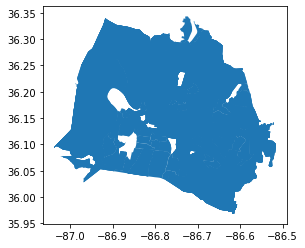

In [37]:
tract_pop_income_burglary.plot()

In [38]:
tract_pop_income_burglary['Population']=tract_pop_income_burglary['Population'].astype(int)

In [39]:
tract_pop_income_burglary = tract_pop_income_burglary[tract_pop_income_burglary['Population'] > 0]

In [40]:
tract_pop_income_burglary.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 993 entries, 0 to 997
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   STATEFP                      993 non-null    object  
 1   COUNTYFP                     993 non-null    object  
 2   TRACTCE                      993 non-null    object  
 3   GEOID                        993 non-null    object  
 4   NAME                         993 non-null    object  
 5   NAMELSAD                     993 non-null    object  
 6   MTFCC                        993 non-null    object  
 7   FUNCSTAT                     993 non-null    object  
 8   ALAND                        993 non-null    int64   
 9   AWATER                       993 non-null    int64   
 10  INTPTLAT                     993 non-null    object  
 11  INTPTLON                     993 non-null    object  
 12  geometry                     993 non-null    geometry
 1

In [41]:
total_burglaries = (tract_pop_income_burglary
                   .drop_duplicates('incident_number')
                   .groupby('TRACTCE')['offense_description']
                   .count())


In [42]:
total_burglaries = pd.DataFrame(total_burglaries)
total_burglaries = total_burglaries.rename(columns = {'offense_description': 'burglaries_count'})

In [43]:
tract_pop_income_burglary = tract_pop_income_burglary.merge(total_burglaries, on = 'TRACTCE')

In [44]:
tract_pop_income_burglary.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 993 entries, 0 to 992
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   STATEFP                      993 non-null    object  
 1   COUNTYFP                     993 non-null    object  
 2   TRACTCE                      993 non-null    object  
 3   GEOID                        993 non-null    object  
 4   NAME                         993 non-null    object  
 5   NAMELSAD                     993 non-null    object  
 6   MTFCC                        993 non-null    object  
 7   FUNCSTAT                     993 non-null    object  
 8   ALAND                        993 non-null    int64   
 9   AWATER                       993 non-null    int64   
 10  INTPTLAT                     993 non-null    object  
 11  INTPTLON                     993 non-null    object  
 12  geometry                     993 non-null    geometry
 1

In [45]:
tract_pop_income_burglary = tract_pop_income_burglary.dropna(subset = ['Population'])
tract_pop_income_burglary['burglaries_per_1000'] =  (tract_pop_income_burglary['burglaries_count']*1000/
                                                           tract_pop_income_burglary['Population'])

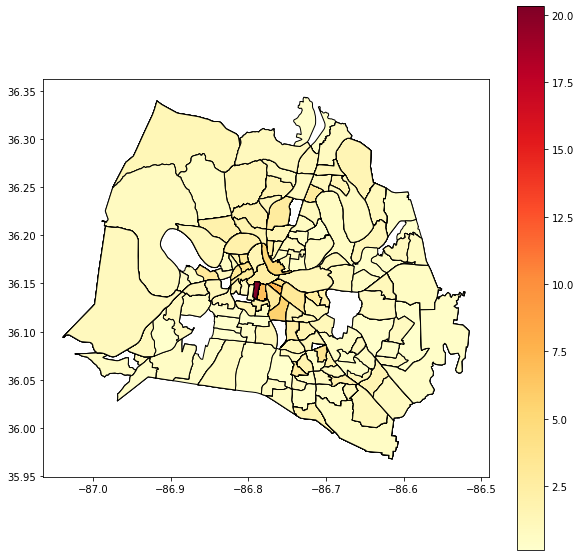

In [46]:
fig, ax = plt.subplots(figsize = (10,10))

tract_pop_income_burglary.plot(column = 'burglaries_per_1000',
                               cmap = 'YlOrRd',
                               legend = True,
                               edgecolor = 'black',
                               ax = ax);


# 5

In [47]:
tract_pop_income_burglary['log_population'] = np.log(tract_pop_income_burglary['Population'])

In [48]:
modeling_tract_gdf = tract_pop_income_burglary.drop_duplicates(subset = ['TRACTCE'])
modeling_tract_gdf['Median Income'] = modeling_tract_gdf['Median Income'].astype(float)
modeling_tract_gdf = modeling_tract_gdf[modeling_tract_gdf['Median Income'] > 0]

C:\Users\jacob\Anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [61]:
modeling_tract_gdf.sort_values('Median Income')

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,Median Income,Population,burglaries_count,burglaries_per_1000,log_population
723,47,037,019300,47037019300,193,Census Tract 193,G5020,S,3504255,493345,...,F,B,Non-Hispanic,RESIDENT,POINT (-86.76 36.16),14277.0,3428,18,5.250875,8.139732
501,47,037,014800,47037014800,148,Census Tract 148,G5020,S,759493,0,...,NaN,NaN,NaN,NaN,POINT (-86.76 36.15),15730.0,3310,14,4.229607,8.104703
819,47,037,015900,47037015900,159,Census Tract 159,G5020,S,5527142,0,...,M,W,Hispanic,RESIDENT,POINT (-86.73 36.12),18520.0,2865,9,3.141361,7.960324
883,47,037,010904,47037010904,109.04,Census Tract 109.04,G5020,S,2449037,0,...,M,B,Non-Hispanic,NON RESIDENT,POINT (-86.78 36.23),23514.0,3213,4,1.244942,8.074960
485,47,037,014200,47037014200,142,Census Tract 142,G5020,S,1080635,0,...,M,W,Non-Hispanic,NON RESIDENT,POINT (-86.8 36.17),23799.0,2024,8,3.952569,7.612831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,47,037,017902,47037017902,179.02,Census Tract 179.02,G5020,S,3967487,0,...,F,W,Non-Hispanic,RESIDENT,POINT (-86.84 36.1),128141.0,4992,1,0.200321,8.515592
925,47,037,017701,47037017701,177.01,Census Tract 177.01,G5020,S,5280371,0,...,M,W,Non-Hispanic,RESIDENT,POINT (-86.77 36.09),134786.0,2466,3,1.216545,7.810353
480,47,037,018700,47037018700,187,Census Tract 187,G5020,S,19794602,302117,...,M,W,Unknown,RESIDENT,POINT (-86.79 36.08),183750.0,3197,1,0.312793,8.069968
475,47,037,018602,47037018602,186.02,Census Tract 186.02,G5020,S,17222162,4486,...,F,W,Non-Hispanic,RESIDENT,POINT (-86.84 36.06),188375.0,4187,3,0.716503,8.339740


In [50]:
#poisson base model

poisson_base_model = (sm.GLM(endog = modeling_tract_gdf['burglaries_count'],
                           exog =sm.add_constant(modeling_tract_gdf['Median Income']), 
                           offset = modeling_tract_gdf['log_population'],
                            family = sm.families.Poisson())
                      .fit())

C:\Users\jacob\Anaconda3\envs\geospatial\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [51]:
poisson_base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -483.48
Date:                Thu, 07 Oct 2021   Deviance:                       494.42
Time:                        21:11:59   Pearson chi2:                     990.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.6965      0.102    -55.656      0.000      -5.897      -5.496
Median Income -1.702e-05   1.74e-06     -9.797      0.000   -2.04e-05   -1.36e-05
=================================================================================
"""

In [64]:
poisson_base_model.params[0]
income_range = np.linspace(14277,190375, num = 50 )

In [66]:
poisson_line = np.exp(poisson_base_model.params[0]+poisson_base_model.params[1]*income_range)

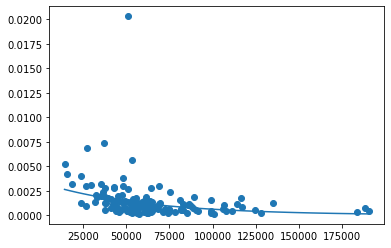

In [69]:
plt.scatter(x= modeling_tract_gdf['Median Income'],
            y = (modeling_tract_gdf['burglaries_count']/modeling_tract_gdf['Population']));
plt.plot(income_range, poisson_line)